In [20]:
R.version

               _                           
platform       x86_64-conda_cos6-linux-gnu 
arch           x86_64                      
os             linux-gnu                   
system         x86_64, linux-gnu           
status                                     
major          3                           
minor          6.1                         
year           2019                        
month          07                          
day            05                          
svn rev        76782                       
language       R                           
version.string R version 3.6.1 (2019-07-05)
nickname       Action of the Toes          

In [21]:
library("dplyr")
library("glue")
library("stringr")
library("rlist")
library("data.table")
library("readr")
library("stringi")
library("swat")

In [22]:
source("UtilsRCAS.R")

# Connection a l'environnement SAS Viya

In [23]:
Sys.setenv(CAS_CLIENT_SSL_CA_LIST = "/opt/sas/viya/config/etc/SASSecurityCertificateFramework/cacerts/trustedcerts.pem")
cashost <- 'controller'
casuser <- 'sebastien'

conn <- swat::CAS(cashost, 5570, username=casuser)

# Activate metric tracing and other session parameters
out <- cas.sessionProp.setSessOpt(conn, metrics=TRUE, timeout=1800, caslib='casuser')

NOTE: Connecting to CAS and generating CAS action functions for loaded
      action sets...
NOTE: To generate the functions with signatures (for tab completion), set 
      options(cas.gen.function.sig=TRUE).
NOTE: 'CASUSER(sebastien)' is now the active caslib.
NOTE: Action 'sessionProp.setSessOpt' used (Total process time):
NOTE:       real time               0.014292 seconds
NOTE:       cpu time                0.028502 seconds (199.43%)
NOTE:       total nodes             5 (76 cores)
NOTE:       total memory            515.57G
NOTE:       memory                  1.44M (0.00%)


In [24]:
actionsets <- c('fedsql','aggregation')
for(i in actionsets){
    loadActionSet(conn, i)
}

NOTE: Executing action 'builtins.loadActionSet'.
NOTE: Added action set 'fedsql'.
NOTE: Action 'builtins.loadActionSet' used (Total process time):
NOTE:       real time               0.014832 seconds
NOTE:       cpu time                0.034329 seconds (231.45%)
NOTE:       total nodes             5 (76 cores)
NOTE:       total memory            515.57G
NOTE:       memory                  1.30M (0.00%)
NOTE: Executing action 'builtins.actionSetInfo'.
NOTE: Action 'builtins.actionSetInfo' used (Total process time):
NOTE:       real time               0.008330 seconds
NOTE:       cpu time                0.018753 seconds (225.13%)
NOTE:       total nodes             5 (76 cores)
NOTE:       total memory            515.57G
NOTE:       memory                  1.62M (0.00%)
NOTE: Executing action 'builtins.listActions'.
NOTE: Information for action set 'fedSql':
NOTE:    fedSql
NOTE:       execDirect - Submits a SAS FedSQL language statement for immediate execution
NOTE: Action 'builtins.lis

In [25]:
cas.builtins.serverStatus(conn)

NOTE: Executing action 'builtins.serverStatus'.
NOTE: Grid node action status report: 5 nodes, 34 total actions executed.
NOTE: Action 'builtins.serverStatus' used (Total process time):
NOTE:       real time               0.008244 seconds
NOTE:       cpu time                0.015628 seconds (189.57%)
NOTE:       total nodes             5 (76 cores)
NOTE:       total memory            515.57G
NOTE:       memory                  1.52M (0.00%)


$About
$About$CAS
[1] "Cloud Analytic Services"

$About$Version
[1] "3.05"

$About$VersionLong
[1] "V.03.05M0P11112019"

$About$Copyright
[1] "Copyright © 2014-2018 SAS Institute Inc. All Rights Reserved."

$About$ServerTime
[1] "2020-05-04T15:04:35Z"

$About$System
$About$System$Hostname
[1] "controller.c.sas-ag2r-la-mondiale.internal"

$About$System$`OS Name`
[1] "Linux"

$About$System$`OS Family`
[1] "LIN X64"

$About$System$`OS Release`
[1] "3.10.0-1127.el7.x86_64"

$About$System$`OS Version`
[1] "#1 SMP Tue Mar 31 23:36:51 UTC 2020"

$About$System$`Model Number`
[1] "x86_64"

$About$System$`Linux Distribution`
[1] "CentOS Linux release 7.8.2003 (Core)"


$About$license
$About$license$site
[1] "BDF"

$About$license$siteNum
[1] 70180938

$About$license$expires
[1] "29Apr2021:00:00:00"

$About$license$gracePeriod
[1] 45

$About$license$warningPeriod
[1] 45



$server
  nodes actions
1     5      34

$nodestatus
                                        name       role uptime running stalled
1    worker1.c.sas-ag2r-la-mondiale.internal     worker  1.883       0       0
2    worker2.c.sas-ag2r-la-mondiale.internal     worker  1.883       0       0
3    worker3.c.sas-ag2r-la-mondiale.internal     worker  1.883       0       0
4    worker4.c.sas-ag2r-la-mondiale.internal     worker  1.882       0       0
5 controller.c.sas-ag2r-la-mondiale.internal controller  1.941       0       0

## Demarrage du traitement. On va pointer sur une librairie CAS déja declaree dans la plateforme et pointant sur le repertoire contenant tous les fichiers CSV en entree (ou sur l'instance de la base Oracle ou Hive). Pour les fichiers, on definie la source en DNFS, cela signifie que la lecture et l'ecriture des fichiers se fera en multitheading et multi noeud automatiquement. Les formats de fichiers supportes actuellement sur ce mode sont : CSV, PARQUET et SASHDAT.

In [26]:
HeureDebut <- Sys.time()

#cas.table.addCaslib(conn,name="mycaslib", path="/data/data/BDF_SMALL_DB", dataSource={srcType="dnfs"})
#cas.table.addCaslib(conn,name="mycaslib", path="/SAS/BDF", dataSource={srcType="dnfs"})
out <- cas.sessionProp.setSessOpt(conn,caslib='casuser')

NOTE: Executing action 'sessionProp.setSessOpt'.
NOTE: 'CASUSER(sebastien)' is now the active caslib.
NOTE: Action 'sessionProp.setSessOpt' used (Total process time):
NOTE:       real time               0.007397 seconds
NOTE:       cpu time                0.017534 seconds (237.04%)
NOTE:       total nodes             5 (76 cores)
NOTE:       total memory            515.57G
NOTE:       memory                  1.35M (0.00%)


# Chargement en memoire de tous les fichiers CSV en entree (referentiel et agregats) pour l'utilisation ulterieure.

In [27]:
import_all_csv_in_memory(conn, 'BDF_DNFS','casuser', fileflag=1)

NOTE: Executing action 'table.fileInfo'.
NOTE: Action 'table.fileInfo' used (Total process time):
NOTE:       real time               0.012281 seconds
NOTE:       cpu time                0.019732 seconds (160.67%)
NOTE:       total nodes             5 (76 cores)
NOTE:       total memory            515.57G
NOTE:       memory                  1.90M (0.00%)
NOTE: Executing action 'table.dropTable'.
NOTE: Action 'table.dropTable' used (Total process time):
NOTE:       real time               0.011790 seconds
NOTE:       cpu time                0.020390 seconds (172.94%)
NOTE:       total nodes             5 (76 cores)
NOTE:       total memory            515.57G
NOTE:       memory                  1.46M (0.00%)
NOTE: Executing action 'table.loadTable'.
NOTE: Cloud Analytic Services made the DNFS file D1.csv available as table D1 in caslib CASUSER(sebastien).
NOTE: Action 'table.loadTable' used (Total process time):
NOTE:       real time               17.511954 seconds
NOTE:       cpu time  

In [28]:
cas.table.tableInfo(conn,caslib="casuser")

NOTE: Executing action 'table.tableInfo'.
NOTE: Action 'table.tableInfo' used (Total process time):
NOTE:       real time               0.006237 seconds
NOTE:       cpu time                0.014069 seconds (225.57%)
NOTE:       total nodes             5 (76 cores)
NOTE:       total memory            515.57G
NOTE:       memory                  1.94M (0.00%)


Name,Rows,Columns,IndexedColumns,Encoding,CreateTimeFormatted,ModTimeFormatted,AccessTimeFormatted,JavaCharSet,CreateTime,...,Repeated,View,MultiPart,SourceName,SourceCaslib,Compressed,Creator,Modifier,SourceModTimeFormatted,SourceModTime
D1,21648241,8,0,utf-8,2020-05-04T15:04:35+00:00,2020-05-04T15:04:35+00:00,2020-05-04T15:04:35+00:00,UTF8,1904223875,...,0,0,0,D1.csv,BDF_DNFS,0,sebastien,,2020-05-04T14:44:07+00:00,1904222647
D2,6472521,8,0,utf-8,2020-05-04T15:04:53+00:00,2020-05-04T15:04:53+00:00,2020-05-04T15:04:53+00:00,UTF8,1904223893,...,0,0,0,D2.csv,BDF_DNFS,0,sebastien,,2020-05-04T14:44:25+00:00,1904222665
D3,18196935,8,0,utf-8,2020-05-04T15:05:04+00:00,2020-05-04T15:05:04+00:00,2020-05-04T15:05:04+00:00,UTF8,1904223904,...,0,0,0,D3.csv,BDF_DNFS,0,sebastien,,2020-05-04T14:44:56+00:00,1904222696
F,597409,8,0,utf-8,2020-05-04T15:05:37+00:00,2020-05-04T15:05:37+00:00,2020-05-04T15:05:37+00:00,UTF8,1904223937,...,0,0,0,F.csv,BDF_DNFS,0,sebastien,,2020-05-04T14:45:03+00:00,1904222703
O,28344903,8,0,utf-8,2020-05-04T15:05:38+00:00,2020-05-04T15:05:38+00:00,2020-05-04T15:05:38+00:00,UTF8,1904223938,...,0,0,0,O.csv,BDF_DNFS,0,sebastien,,2020-05-04T14:45:45+00:00,1904222745
P,9530865,8,0,utf-8,2020-05-04T15:06:28+00:00,2020-05-04T15:06:28+00:00,2020-05-04T15:06:28+00:00,UTF8,1904223988,...,0,0,0,P.csv,BDF_DNFS,0,sebastien,,2020-05-04T14:46:07+00:00,1904222767
PLANAGREGATION,533,41,0,utf-8,2020-05-04T15:06:44+00:00,2020-05-04T15:06:44+00:00,2020-05-04T15:06:44+00:00,UTF8,1904224004,...,0,0,0,PLANAGREGATION.csv,BDF_DNFS,0,sebastien,,2020-05-04T14:46:11+00:00,1904222771
TABLEPAYSZONE,3953,5,0,utf-8,2020-05-04T15:06:44+00:00,2020-05-04T15:06:44+00:00,2020-05-04T15:06:44+00:00,UTF8,1904224004,...,0,0,0,TABLEPAYSZONE.csv,BDF_DNFS,0,sebastien,,2020-05-04T14:46:11+00:00,1904222771
U1,14835007,8,0,utf-8,2020-05-04T15:06:44+00:00,2020-05-04T15:06:44+00:00,2020-05-04T15:06:44+00:00,UTF8,1904224004,...,0,0,0,U1.csv,BDF_DNFS,0,sebastien,,2020-05-04T14:46:34+00:00,1904222794
U2,13390747,8,0,utf-8,2020-05-04T15:07:11+00:00,2020-05-04T15:07:11+00:00,2020-05-04T15:07:11+00:00,UTF8,1904224031,...,0,0,0,U2.csv,BDF_DNFS,0,sebastien,,2020-05-04T14:46:59+00:00,1904222819


## Concatenation totale de toutes les tables d'agregat en mémoire pour former une table nommee AGGTTECATEGORIE

In [29]:
cas_concat_all_tables(conn, "casuser","casuser","AGGTTECATEGORIE")
table_AggregationMensuelleTouteCategorie <- defCasTable(conn, tablename='AGGTTECATEGORIE', caslib='casuser')
nrow(table_AggregationMensuelleTouteCategorie)

NOTE: Executing action 'table.tableInfo'.
NOTE: Action 'table.tableInfo' used (Total process time):
NOTE:       real time               0.006632 seconds
NOTE:       cpu time                0.014130 seconds (213.06%)
NOTE:       total nodes             5 (76 cores)
NOTE:       total memory            515.57G
NOTE:       memory                  1.94M (0.00%)
NOTE: Executing action 'table.dropTable'.
NOTE: Action 'table.dropTable' used (Total process time):
NOTE:       real time               0.010233 seconds
NOTE:       cpu time                0.018169 seconds (177.55%)
NOTE:       total nodes             5 (76 cores)
NOTE:       total memory            515.57G
NOTE:       memory                  1.46M (0.00%)
NOTE: Executing action 'dataStep.runCode'.
NOTE: Action 'dataStep.runCode' used (Total process time):
NOTE:       real time               1.257381 seconds
NOTE:       cpu time                33.346351 seconds (2652.05%)
NOTE:       total nodes             5 (76 cores)
NOTE:       t

[1] 157620504

## Produire la repartition en nombre d'enregistrements par categorie a partir de l'agregation faite en memoire par le moteur CAS sur la table globale AGGTTECATEGORIE et la recuperation de ces agregats en entree de la fonction PIE de R

NOTE: Executing action 'simple.freq'.
NOTE: Action 'simple.freq' used (Total process time):
NOTE:       real time               1.131964 seconds
NOTE:       cpu time                47.988781 seconds (4239.43%)
NOTE:       total nodes             5 (76 cores)
NOTE:       total memory            515.57G
NOTE:       memory                  75.44M (0.01%)
NOTE:       bytes moved             1.45K


casLib,Name,Rows,Columns
CASUSER(sebastien),AGGTTECATEGORIE_freq,11,5


NOTE: Executing action 'table.fetch'.
NOTE: Action 'table.fetch' used (Total process time):
NOTE:       real time               0.018251 seconds
NOTE:       cpu time                0.068283 seconds (374.13%)
NOTE:       total nodes             5 (76 cores)
NOTE:       total memory            515.57G
NOTE:       memory                  12.22M (0.00%)


$Fetch
   _Index_  _Column_ _Charvar_ _Fmtvar_ _Level_ _Frequency_
1        1 tablename         D        D       7    32038933
2        2 tablename         O        O       5    28344903
3        3 tablename        D1       D1       9    21648241
4        4 tablename        D3       D3       4    18196935
5        5 tablename        U1       U1      11    14835007
6        6 tablename        U2       U2       1    13390747
7        7 tablename         P        P      10     9530865
8        8 tablename         Z        Z       3     6486954
9        9 tablename        D2       D2       8     6472521
10      10 tablename        U3       U3       2     6077989
11      11 tablename         F        F       6      597409



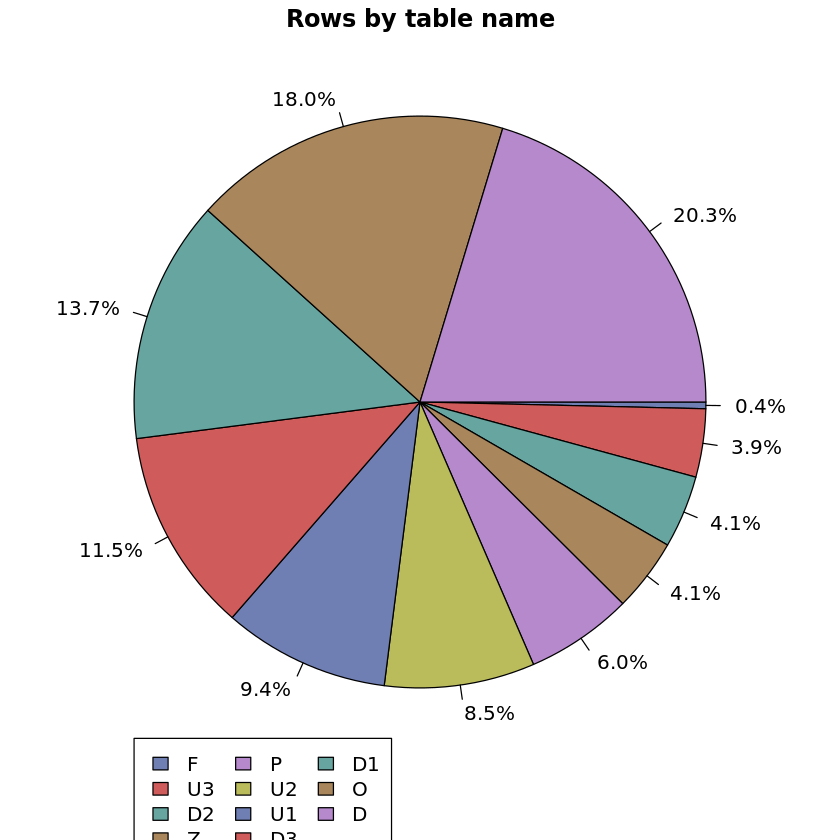

In [30]:
cas.simple.freq(conn, inputs = c("tablename"),table = c(name = "AGGTTECATEGORIE"),casout = c(name = "AGGTTECATEGORIE_freq", replace = TRUE)) 
res <- cas.table.fetch(conn, table = "AGGTTECATEGORIE_freq", sortBy = list(list(name = "_Frequency_",order = "descending")))
print(res)
piedata <- res$Fetch                                              # 
names(piedata) <- gsub("_", "", names(piedata))
piedata <- piedata[order(piedata$Frequency),]
total <- sum(piedata$Frequency)
piedata$Percent <- scales::percent(piedata$Frequency / total)
fillcolors = c("#6F7EB3", "#D05B5B", "#66A5A0", "#A9865B","#B689CD", "#BABC5C")
par(mar = c(3, 0, 1.5, 0), xpd=TRUE)
pie(piedata$Frequency,labels = piedata$Percent, col=fillcolors, radius=0.85, clockwise=TRUE, init.angle=0, main="Rows by table name")
legend(x=-0.85, y=-1, horiz = FALSE, piedata$Charvar, fill = fillcolors, ncol=3)

## Declaration des table CAS en tant qu'objet de type CASTable en R

In [31]:
table_pays_zone <- defCasTable(conn, tablename='TABLEPAYSZONE', caslib='casuser')
table_planAggregation <- defCasTable(conn, tablename='PLANAGREGATION', caslib='casuser')

NOTE: Executing action 'table.columnInfo'.
NOTE: Action 'table.columnInfo' used (Total process time):
NOTE:       real time               0.005712 seconds
NOTE:       cpu time                0.013522 seconds (236.73%)
NOTE:       total nodes             5 (76 cores)
NOTE:       total memory            515.57G
NOTE:       memory                  2.56M (0.00%)
NOTE: Executing action 'table.columnInfo'.
NOTE: Action 'table.columnInfo' used (Total process time):
NOTE:       real time               0.005984 seconds
NOTE:       cpu time                0.013594 seconds (227.17%)
NOTE:       total nodes             5 (76 cores)
NOTE:       total memory            515.57G
NOTE:       memory                  2.56M (0.00%)


# Code principal basé sur le programme R existant

## Fonction de traitement principal

In [32]:
traitement_principal <- function(freq, RevFin, PeriodeFin, planAggregation,ReferencePiZones, Repertoire, ConnectionSecureDB)
{
  Frequence <- freq
  HeureDebut <- Sys.time()
  An = as.numeric(ExtractString(PeriodeFin, 1, 4))
  print("ETAPE DATA: LECTURE TABLE PI_ZONE")
  print(Sys.time())
  TablePiZone <- recuperation_traitement_table_code_pays(ReferencePiZones, ConnectionSecureDB)
  #return(TablePiZone)
  print(" TAILLE TABLE TablePaysZone")
  print(dim(TablePiZone))
  print(Sys.time())
  print("LECTURE ET MISE EN FORME DES FICHIERS D'AGGREGATION CODE SERIE")
  print(Sys.time())
  # planAggregation <- "PlanAggregation.csv"
  planAgregationCodeSerie <- lecture_fichier_aggregation_codeSerie(planAggregation, connectionSecureDB)
  # # write_delim(planAgregationCodeSerie, "planAgregationCodeSerie.csv", delim=";")
  print(" TAILLE TABLE planAgregationCodeSerie")
  print(dim(planAgregationCodeSerie))
  print(Sys.time())
  print("JOINTURE PLAN D'AGGREGATION")
  PlanAggregationParametre <- parametrage_aggregation_code_serie(planAgregationCodeSerie, TablePiZone, freq) 
    
  # # write_delim(PlanAggregationParametre, "PlanAggregationParametre.csv", delim=";")
  print("Taille plan d'agregation")
  print(dim(PlanAggregationParametre))
  print(names(PlanAggregationParametre))

  # Ecriture du dataframe de sortie en table CAS pour les futures jointures
  PlanAggregationParametreCAS <- as.casTable(ConnectionSecureDB, PlanAggregationParametre, casOut=list(caslib="casuser", name="PLANAGGPARAM",replace=TRUE))
  print(dim(PlanAggregationParametreCAS))
    
  print("ESTIMATION NOMBRE DE PERIODE ET DE DEBUT DE TRAITEMENT")
  result_nbperiode_moisdebut <- detection_nbPeriode_moisDebut(freq, RevFin, PeriodeFin)
  NbrePeriode <- result_nbperiode_moisdebut$nbper
  MoisDebut <- as.numeric(result_nbperiode_moisdebut$moisDebut)
  print(MoisDebut)
  
  rm(result_nbperiode_moisdebut)
  
  print("BOUCLE DU LES MOIS")

 # On supprime la table d'agregat finale si elle existe avant de la reconstruire de la boucle mensuelle suivante   
 cas.table.dropTable(conn, caslib='casuser', name='AGG_FINALE', quiet=TRUE)
    
  for(mois in MoisDebut:(MoisDebut+NbrePeriode-1))
  {
     print(paste0("     Mois debut ", MoisDebut))
     print(paste0("     Mois fin ", (MoisDebut+NbrePeriode-1)))
     print(paste0("     Mois en cours de traitement: ", mois))
     
     print(Sys.time())
     
     print("                      lecture")

     AggregationMensuelleTouteCategorie <- lecture_tables_aggregation(freq, Mois, RevFin, PeriodeFin, Repertoire, ConnectionSecureDB,'AGGTTECATEGORIE','AGG_MENS_TEMP')
     print("Taille table d'agregation")
     print(dim(AggregationMensuelleTouteCategorie))
     print(names(AggregationMensuelleTouteCategorie))
      
     TableIdMixte <- lecture_tables_mixte(freq, Mois, RevFin, PeriodeFin, Repertoire, ConnectionSecureDB,'AGGTTECATEGORIE','AGG_MIXTE')
     print(dim(TableIdMixte))
     print(names(TableIdMixte))
     print(Sys.time())
     
     print("PARAMETRAGE CODE SERIE") 
     
     print("APPLICATION PARAMETRAGE CODE SERIE") 
     
     AggregationCodeSerieFinaleMensuelle <- application_plan_parametrage_aggregation_code_serie_mensuel('AGG_MENS_TEMP', 'PLANAGGPARAM', ConnectionSecureDB,'AGG_MENS')
     print(names(AggregationCodeSerieFinaleMensuelle))
      
     # On ajoute la table mensuelle à la table globale finale
     cas_append2tables(conn, 'casuser', 'AGG_MENS', 'casuser', 'AGG_FINALE')
  }
}

## Definition des variables

In [33]:
Repertoire <- "AC156203"
RevFin<- "SD10"
PeriodeFin <- "2018Q4"
freq <- "Q"
planAggregation <- table_planAggregation
ReferencePiZones <- table_pays_zone
ConnectionSecureDB <- conn # Connexion securisee a la session CAS

In [34]:
traitement_principal(freq, RevFin, PeriodeFin, planAggregation,ReferencePiZones, Repertoire, ConnectionSecureDB)

[1] "ETAPE DATA: LECTURE TABLE PI_ZONE"
[1] "2020-05-04 15:08:14 UTC"
[1] "recuperation_traitement_table_code_pays monostream"
[1] "2020-05-04 15:08:14 UTC"


NOTE: Executing action 'table.fetch'.
NOTE: Action 'table.fetch' used (Total process time):
NOTE:       real time               0.085651 seconds
NOTE:       cpu time                0.096375 seconds (112.52%)
NOTE:       total nodes             5 (76 cores)
NOTE:       total memory            515.57G
NOTE:       memory                  8.22M (0.00%)
Column 1 ['code_zone'] of item 2 is missing in item 1. Use fill=TRUE to fill with NA (NULL for list columns), or use.names=FALSE to ignore column names. use.names='check' (default from v1.12.2) emits this message and proceeds as if use.names=FALSE for  backwards compatibility. See news item 5 in v1.12.2 for options to control this message.


[1] "end recuperation_traitement_table_code_pays monostream"
[1] "2020-05-04 15:08:20 UTC"
[1] " TAILLE TABLE TablePaysZone"
[1] 445   3
[1] "2020-05-04 15:08:20 UTC"
[1] "LECTURE ET MISE EN FORME DES FICHIERS D'AGGREGATION CODE SERIE"
[1] "2020-05-04 15:08:20 UTC"
[1] "lecture_fichier_aggregation_codeSerie monostream"


NOTE: Executing action 'table.fetch'.
NOTE: Action 'table.fetch' used (Total process time):
NOTE:       real time               0.028065 seconds
NOTE:       cpu time                0.049882 seconds (177.74%)
NOTE:       total nodes             5 (76 cores)
NOTE:       total memory            515.57G
NOTE:       memory                  7.37M (0.00%)


[1] " TAILLE TABLE planAgregationCodeSerie"
[1] 2697    3
[1] "2020-05-04 15:08:24 UTC"
[1] "JOINTURE PLAN D'AGGREGATION"
[1] "parametrage_aggregation_code_serie monostream"
[1] "2020-05-04 15:08:24 UTC"
[1] "Recuperation des positions et longueur parents dans les codes"
[1] "Recuperation des positions et longueur des parametres dans les codes"
[1] "2020-05-04 15:08:25 UTC"
[1] "Recuperation des positions et longueur des index dans les codes"
[1] "2020-05-04 15:08:26 UTC"
[1] "9 GB"
[1] "Creation des variables cd2_, cd3_, cd1_, refsec, countsec par decoupage des codes"
[1] "2020-05-04 15:08:26 UTC"
[1] "Modification conditionnelle des valeurs de code entree et code sortie"
[1] "2020-05-04 15:08:26 UTC"
[1] "Jointure de la table AggregationTable TablePiZone"
[1] 7125   20
 [1] "code_sortie"       "code_entree"       "formule"          
 [4] "enfants"           "parents"           "cle"              
 [7] "ind_"              "PositionEnfant"    "LongueurEnfant"   
[10] "PositionParametre

Warning message in if (class(data) == "character") {:
“the condition has length > 1 and only the first element will be used”NOTE: Executing action 'table.columnInfo'.
NOTE: Action 'table.columnInfo' used (Total process time):
NOTE:       real time               0.006140 seconds
NOTE:       cpu time                0.013997 seconds (227.96%)
NOTE:       total nodes             5 (76 cores)
NOTE:       total memory            515.57G
NOTE:       memory                  2.54M (0.00%)
NOTE: Executing action 'simple.numRows'.
NOTE: Action 'simple.numRows' used (Total process time):
NOTE:       real time               0.006664 seconds
NOTE:       cpu time                0.015135 seconds (227.12%)
NOTE:       total nodes             5 (76 cores)
NOTE:       total memory            515.57G
NOTE:       memory                  2.08M (0.00%)


[1] 2639427       3
[1] "ESTIMATION NOMBRE DE PERIODE ET DE DEBUT DE TRAITEMENT"
[1] "detection_nbPeriode_moisDebut monostream"
[1] 201812
[1] "BOUCLE DU LES MOIS"


NOTE: Executing action 'table.dropTable'.
NOTE: Action 'table.dropTable' used (Total process time):
NOTE:       real time               0.008277 seconds
NOTE:       cpu time                0.014264 seconds (172.33%)
NOTE:       total nodes             5 (76 cores)
NOTE:       total memory            515.57G
NOTE:       memory                  1.48M (0.00%)


[1] "     Mois debut 201812"
[1] "     Mois fin 201812"
[1] "     Mois en cours de traitement: 201812"
[1] "2020-05-04 15:09:03 UTC"
[1] "                      lecture"
[1] "lecture_tables_aggregation monostream"
[1] "2020-05-04 15:09:03 UTC"
[1] "9 GB"
[1] "CHARGEMENT DES TABLES D'AGGREGATION, monostream"
[1] "2020-05-04 15:09:03 UTC"
[1] "TABLES AGREGATION LU DE LA TABLE CAS AGGTTECATEGORIE"


NOTE: Executing action 'fedSql.execDirect'.
NOTE: Table AGG_MENS_TEMP was created in caslib CASUSER(sebastien) with 157620504 rows returned.
NOTE: Action 'fedSql.execDirect' used (Total process time):
NOTE:       real time               10.408881 seconds
NOTE:       cpu time                456.736061 seconds (4387.95%)
NOTE:       total nodes             5 (76 cores)
NOTE:       total memory            515.57G
NOTE:       memory                  328.49M (0.06%)


[1] "end lecture_tables_aggregation monostream"
[1] "2020-05-04 15:09:14 UTC"


NOTE: Executing action 'table.columnInfo'.
NOTE: Action 'table.columnInfo' used (Total process time):
NOTE:       real time               0.006562 seconds
NOTE:       cpu time                0.014752 seconds (224.81%)
NOTE:       total nodes             5 (76 cores)
NOTE:       total memory            515.57G
NOTE:       memory                  2.51M (0.00%)


[1] "Taille table d'agregation"


NOTE: Executing action 'simple.numRows'.
NOTE: Action 'simple.numRows' used (Total process time):
NOTE:       real time               0.007738 seconds
NOTE:       cpu time                0.017466 seconds (225.72%)
NOTE:       total nodes             5 (76 cores)
NOTE:       total memory            515.57G
NOTE:       memory                  2.23M (0.00%)


[1] 157620504         9
[1] "code"         "montant"      "OBS_STATUS"   "CONF_STATUS"  "Periode_deb" 
[6] "revision_deb" "Periode_fin"  "revision_fin" "tablename"   
[1] "lecture_tables_mixte monostream"
[1] "2020-05-04 15:09:14 UTC"
[1] "9 GB"
[1] "end lecture_tables_mixte monostream"
[1] "2020-05-04 15:09:14 UTC"
NULL
NULL
[1] "2020-05-04 15:09:14 UTC"
[1] "PARAMETRAGE CODE SERIE"
[1] "APPLICATION PARAMETRAGE CODE SERIE"
[1] "application_plan_parametrage_aggregation_code_serie_mensuel monostream"
[1] "2020-05-04 15:09:14 UTC"
[1] "2020-05-04 15:09:14 UTC"
[1] "Renomage de variables et traitement d'espace dans les chaines de caratere"
[1] "2020-05-04 15:09:14 UTC"
[1] "Preparation de la jointure des tables PlanAggregationParametre, AggregationMensuelleTouteCategorie"
[1] "2020-05-04 15:09:14 UTC"
[1] "Jointure des tables PlanAggregationParametre, AggregationMensuelleTouteCategorie"


NOTE: Executing action 'fedSql.execDirect'.
 
Methods for full query plan
----------------------------
Number of Joins Performed is : 1
        HashJoin (LEFT) 
          SeqScan from CASUSER(sebastien).AGG_MENS_TEMP 
          SeqScan from CASUSER(sebastien).PLANAGGPARAM 
 
Methods for stage 1
--------------------
        HashJoin (LEFT) 
          SeqScan from CASUSER(sebastien).AGG_MENS_TEMP 
          SeqScan from CASUSER(sebastien).PLANAGGPARAM 
 
NOTE: Table TMP_AGG was created in caslib CASUSER(sebastien) with 157704151 rows returned.
NOTE: Action 'fedSql.execDirect' used (Total process time):
NOTE:       real time               23.970207 seconds
NOTE:       cpu time                893.267113 seconds (3726.57%)
NOTE:       data movement time      0.783109 seconds
NOTE:       total nodes             5 (76 cores)
NOTE:       total memory            515.57G
NOTE:       memory                  4.03G (0.78%)
NOTE:       bytes moved             596.02M


[1] "Taille de la jointure"
[1] "2020-05-04 15:09:38 UTC"
[1] "Calcul des montants ponderes cumules par code_sortie"


NOTE: Executing action 'aggregation.aggregate'.
NOTE: Action 'aggregation.aggregate' used (Total process time):
NOTE:       real time               216.011073 seconds
NOTE:       cpu time                2325.546501 seconds (1076.59%)
NOTE:       total nodes             5 (76 cores)
NOTE:       total memory            515.57G
NOTE:       memory                  113.08G (21.93%)
NOTE: Executing action 'table.columnInfo'.
NOTE: Action 'table.columnInfo' used (Total process time):
NOTE:       real time               0.006458 seconds
NOTE:       cpu time                0.014017 seconds (217.05%)
NOTE:       total nodes             5 (76 cores)
NOTE:       total memory            515.57G
NOTE:       memory                  2.49M (0.00%)


[1] " TAILLE TABLE CalculAggregationCodeSerieMensuel"


NOTE: Executing action 'simple.numRows'.
NOTE: Action 'simple.numRows' used (Total process time):
NOTE:       real time               0.005930 seconds
NOTE:       cpu time                0.015054 seconds (253.86%)
NOTE:       total nodes             5 (76 cores)
NOTE:       total memory            515.57G
NOTE:       memory                  2.16M (0.00%)


[1] 3536105       8
[1] "2020-05-04 15:13:14 UTC"
[1] "code"         "CONF_STATUS"  "OBS_STATUS"   "Periode_deb"  "Periode_fin" 
[6] "revision_deb" "revision_fin" "MONTANT"     


NOTE: Executing action 'dataStep.runCode'.
NOTE: Action 'dataStep.runCode' used (Total process time):
NOTE:       real time               0.250023 seconds
NOTE:       cpu time                6.964404 seconds (2785.51%)
NOTE:       total nodes             5 (76 cores)
NOTE:       total memory            515.57G
NOTE:       memory                  226.55M (0.04%)


In [35]:
# Promotion en memoire pour les utilisateurs et sauvegarde sur disque de la table resultante
cas.table.dropTable(ConnectionSecureDB,name='AGG_FINALE',caslib='BDF_DNFS',quiet=TRUE)
cas.table.promote(ConnectionSecureDB,caslib='casuser',name='AGG_FINALE',target='AGG_FINALE',targetLib='BDF_DNFS')
cas.table.save(ConnectionSecureDB,table=list(name='AGG_FINALE',caslib="BDF_DNFS") , caslib="BDF_DNFS", name="AGG_FINALE.parquet", replace=TRUE)

NOTE: Executing action 'table.dropTable'.
NOTE: Action 'table.dropTable' used (Total process time):
NOTE:       real time               0.058923 seconds
NOTE:       cpu time                0.015152 seconds (25.71%)
NOTE:       total nodes             5 (76 cores)
NOTE:       total memory            515.57G
NOTE:       memory                  1.42M (0.00%)


list()

NOTE: Executing action 'table.promote'.
NOTE: Cloud Analytic Services promoted table AGG_FINALE in caslib CASUSER(sebastien) to table AGG_FINALE in caslib BDF_DNFS.
NOTE: Action 'table.promote' used (Total process time):
NOTE:       real time               0.066901 seconds
NOTE:       cpu time                0.209470 seconds (313.10%)
NOTE:       total nodes             5 (76 cores)
NOTE:       total memory            515.57G
NOTE:       memory                  1.49M (0.00%)


list()

NOTE: Executing action 'table.save'.
NOTE: Cloud Analytic Services saved the file AGG_FINALE.parquet in caslib BDF_DNFS.
NOTE: Action 'table.save' used (Total process time):
NOTE:       real time               1.768441 seconds
NOTE:       cpu time                6.312154 seconds (356.93%)
NOTE:       total nodes             5 (76 cores)
NOTE:       total memory            515.57G
NOTE:       memory                  1.01G (0.20%)


$caslib
[1] "BDF_DNFS"

$name
[1] "AGG_FINALE.parquet"

In [36]:
cas.table.dropTable(ConnectionSecureDB,name='TMP_AGG',caslib='BDF_DNFS',quiet=TRUE)
cas.table.promote(ConnectionSecureDB,caslib='casuser',name='TMP_AGG',target='TMP_AGG',targetLib='BDF_DNFS')
cas.table.save(ConnectionSecureDB,table=list(name='TMP_AGG',caslib="BDF_DNFS"),  caslib="BDF_DNFS", name="TMP_AGG.parquet", replace=TRUE)

Duree <- Sys.time() - HeureDebut

print(Duree)

NOTE: Executing action 'table.dropTable'.
NOTE: Action 'table.dropTable' used (Total process time):
NOTE:       real time               1.154884 seconds
NOTE:       cpu time                0.016510 seconds (1.43%)
NOTE:       total nodes             5 (76 cores)
NOTE:       total memory            515.57G
NOTE:       memory                  1.40M (0.00%)


list()

NOTE: Executing action 'table.promote'.
NOTE: Cloud Analytic Services promoted table TMP_AGG in caslib CASUSER(sebastien) to table TMP_AGG in caslib BDF_DNFS.
NOTE: Action 'table.promote' used (Total process time):
NOTE:       real time               0.394272 seconds
NOTE:       cpu time                1.273664 seconds (323.04%)
NOTE:       total nodes             5 (76 cores)
NOTE:       total memory            515.57G
NOTE:       memory                  3.33M (0.00%)


list()

NOTE: Executing action 'table.save'.
NOTE: Cloud Analytic Services saved the file TMP_AGG.parquet in caslib BDF_DNFS.
NOTE: Action 'table.save' used (Total process time):
NOTE:       real time               177.873985 seconds
NOTE:       cpu time                267.317039 seconds (150.28%)
NOTE:       total nodes             5 (76 cores)
NOTE:       total memory            515.57G
NOTE:       memory                  3.23G (0.63%)


$caslib
[1] "BDF_DNFS"

$name
[1] "TMP_AGG.parquet"

Time difference of 11.70301 mins


In [37]:
# Ferme la session SAS Viya en cours
cas.terminate(conn)

[1] 0

# Fin du notebook